___
# Modeling elastic seismic response & create angle gathers
___

Author : Eric Verschuur, Delft University of Technology \
Date   : May, 2025

## Generating angle gather from elastic PP response in a 1.5D model and fit intercept/gradient

In this demo we will do the following steps:
- Load a 2D elastic model (Rho,Vp,Vs) 
- Extract one vertical cross-section, to be treated as 1.5D model
- Generate an elastic PP response using Kennett reflectivity method
- Apply imaging via the linear Radon (Tau-P) domain as phase shifts
- Analyse the angle-dependent images via Shuey's Intercept/Gradient analysis


### Importing packages
Here we import the necessary Python packages, but also include local functions that are stored in sub-folder "src", contained in the file <tt>"seistools.py"</tt>. \
Therefore, we first add this sub-folder to our search path and then we can use modules from this libary by using the naming convention <tt>"seistools.function_name()"</tt>. \
Also, the package for Kennett elastic modeling is included here.

In [2]:
import os, sys
os.chdir('/home/zwang35/Thesis/inverse_NN')

# Make sure all necessary libraries are loaded import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# local functions
from src import seistools
from src import Kennett

### Step 1: Load the 2D elastic subsurface model

load model with nx=170 and nz=240


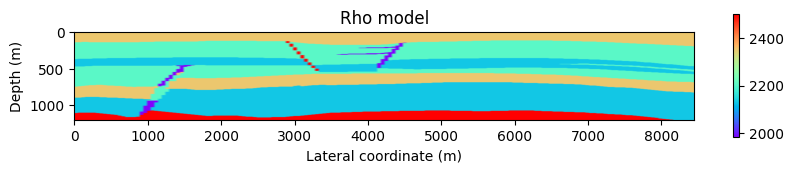

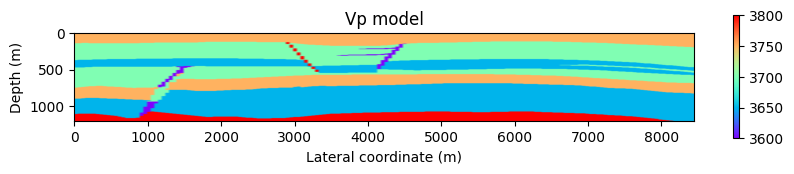

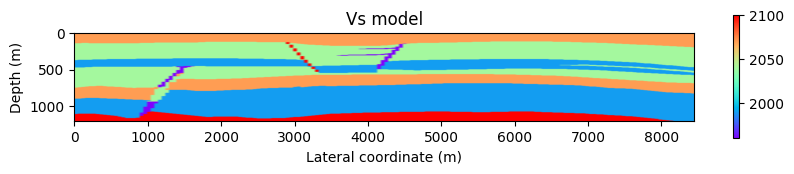

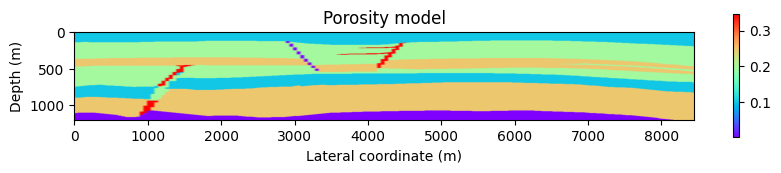

In [3]:
Rho_model = np.flip(np.load('Rho_baseline.npy'),axis=0)
Vp_model = np.flip(np.load('Vp_baseline.npy'),axis=0)
Vs_model = np.flip(np.load('Vs_baseline.npy'),axis=0)
Por_model = np.flip(np.load('porous_volume.npy')/250.0,axis=0)

'''
Rho_over = np.flip(np.load('Rho_overburden.npy'),axis=0)
Vp_over = np.flip(np.load('Vp_overburden.npy'), axis=0)
Vs_over = np.flip(np.load('Vs_overburden.npy'), axis=0)
Por_over = np.load('Por_over.npy')

Rho_syn = np.vstack([Rho_over, Rho_model]) 
Vp_syn = np.vstack([Vp_over, Vp_model]) 
Vs_syn = np.vstack([Vs_over, Vs_model]) 
Por_syn = np.vstack([Por_over, Por_model]) 
'''
dx_model = 50
dz_model = 5
nz_model = Rho_model.shape[0]
nx_model = Rho_model.shape[1]
xax_model=np.arange(nx_model)*dx_model
zax_model=np.arange(nz_model)*dz_model
print('load model with nx=%d and nz=%d' %(nx_model,nz_model))
extent_model=[xax_model[0],xax_model[-1],zax_model[-1],zax_model[0]]

for k in range(4):
    if k == 0:
        tmp=Rho_model
        ext='Rho'
    if k == 1:
        tmp=Vp_model
        ext='Vp'
    if k == 2:
        tmp=Vs_model
        ext='Vs'
    if k == 3:
        tmp=Por_model
        ext='Porosity'
    plt.figure(figsize=(10,4))
    plt.imshow(tmp,cmap='rainbow',extent=extent_model)
    plt.xlabel('Lateral coordinate (m)')
    plt.ylabel('Depth (m)')
    plt.title(ext+' model')
    plt.colorbar(shrink=0.4)
    plt.show()


### Step 2: Select one location and create 1.5 D subsurface model


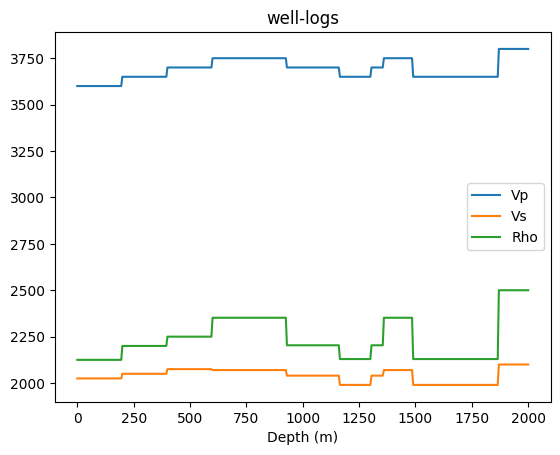

In [4]:
ix=100

#---------------------------------------------------------------
# generate a well-log based on the 2D model cross-section
# the model has basically layers of dz thickness
# note that lateron they will be merged during modeling
#---------------------------------------------------------------

zlayer_target = np.zeros(nz_model)+dz_model
vplayer_target = Vp_model[:,ix]
vslayer_target = Vs_model[:,ix]
rholayer_target = Rho_model[:,ix]
porlayer_target = Por_model[:,ix]

# add an overburden

zlayer_over = [200,200,200,200]
vplayer_over = [3600,3650,3700,vplayer_target[0]]
vslayer_over = [2025,2050,2075,vslayer_target[0]]
rholayer_over = [2125,2200,2250,rholayer_target[0]]
porlayer_over = [0.25,0.2,0.15,rholayer_target[0]]

# merge these two models

zlayer = np.concatenate((zlayer_over,zlayer_target))
vplayer = np.concatenate((vplayer_over,vplayer_target))
vslayer = np.concatenate((vslayer_over,vslayer_target))
rholayer = np.concatenate((rholayer_over,rholayer_target))
porlayer = np.concatenate((porlayer_over,porlayer_target))
zmax=np.sum(zlayer)

# define step size in the well-log and then choose appropiate total depth

dz=5.0
nz=1+int(zmax/dz)
nlayer=len(zlayer)

# make the well-logs via the function

[zlog,vplog,vslog,rholog]=seistools.make_log(nz,dz,zlayer,vplayer,vslayer,rholayer)
            
# make a plot of the logs

plt.figure()
plt.plot(zlog,vplog,label='Vp')
plt.plot(zlog,vslog,label='Vs')
plt.plot(zlog,rholog,label='Rho')
plt.xlabel('Depth (m)')
plt.title('well-logs')
plt.legend()
plt.show()

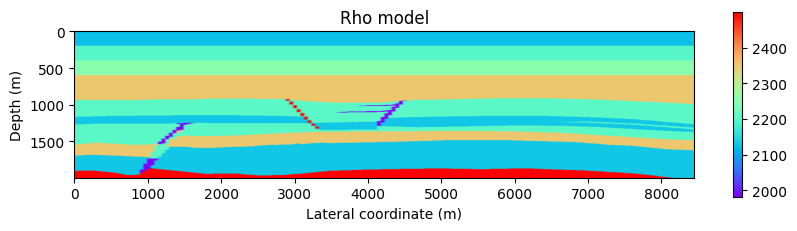

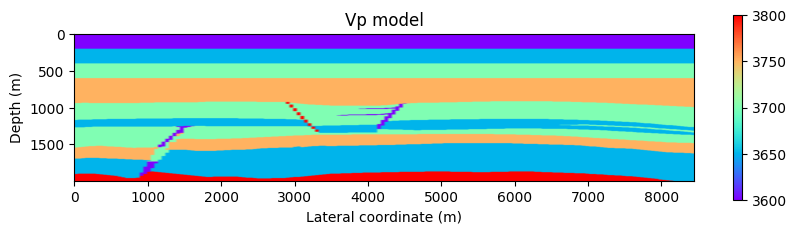

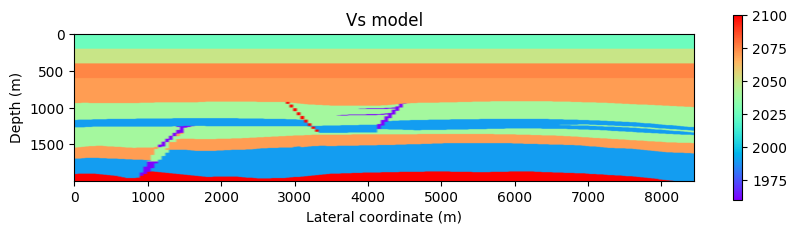

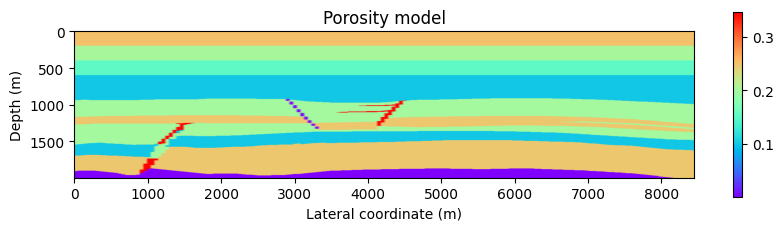

In [5]:
# --- settings ---
nz_target = 400

# layers: 200 m each -> 40 cells each at dz=5
zlayer_over_m = np.array([200, 200, 200, 200], dtype=float)
cells = (zlayer_over_m / dz_model).astype(int)

n_over = nz_target - nz_model


cells[-1] = max(0, n_over - cells[:-1].sum())

# last-layer values taken from the top of the existing model (horizontal median)
vp_last  = float(np.median(Vp_model[0]))
vs_last  = float(np.median(Vs_model[0]))
rho_last = float(np.median(Rho_model[0]))
por_last = float(np.median(Por_model[0]))

vplayer_over  = [3600, 3650, 3700, vp_last]
vslayer_over  = [2025, 2050, 2075, vs_last]
rholayer_over = [2125, 2200, 2250, rho_last]
porlayer_over = [0.25, 0.20, 0.15, por_last]

def build_over(cells, vals, nx):
    return np.vstack([np.full((int(c), nx), float(v), np.float32)
                      for c, v in zip(cells, vals) if int(c) > 0]) if int(np.sum(cells)) > 0 \
           else np.empty((0, nx), np.float32)

Vp_over  = build_over(cells, vplayer_over,  nx_model)
Vs_over  = build_over(cells, vslayer_over,  nx_model)
Rho_over = build_over(cells, rholayer_over, nx_model)
Por_over = build_over(cells, porlayer_over, nx_model)

# pad on top
Vp_pad  = np.vstack([Vp_over,  Vp_model]).astype(np.float32)
Vs_pad  = np.vstack([Vs_over,  Vs_model]).astype(np.float32)
Rho_pad = np.vstack([Rho_over, Rho_model]).astype(np.float32)
Por_pad = np.vstack([Por_over, Por_model]).astype(np.float32)

assert Vp_pad.shape[0] == nz_target and Vs_pad.shape == Vp_pad.shape \
       and Rho_pad.shape == Vp_pad.shape and Por_pad.shape == Vp_pad.shape


zax_pad=np.arange(nz_target)*dz_model
extent_pad=[xax_model[0],xax_model[-1],zax_pad[-1],zax_pad[0]]

for k in range(4):
    if k == 0:
        tmp=Rho_pad
        ext='Rho'
    if k == 1:
        tmp=Vp_pad
        ext='Vp'
    if k == 2:
        tmp=Vs_pad
        ext='Vs'
    if k == 3:
        tmp=Por_pad
        ext='Porosity'
    plt.figure(figsize=(10,6))
    plt.imshow(tmp,cmap='rainbow',extent=extent_pad)
    plt.xlabel('Lateral coordinate (m)')
    plt.ylabel('Depth (m)')
    plt.title(ext+' model')
    plt.colorbar(shrink=0.4)
    plt.show()

### Step 2: Do the modeling of the seismic PP response via Kennett's reflectivity method

Set the modeling parameters and define the wavelet

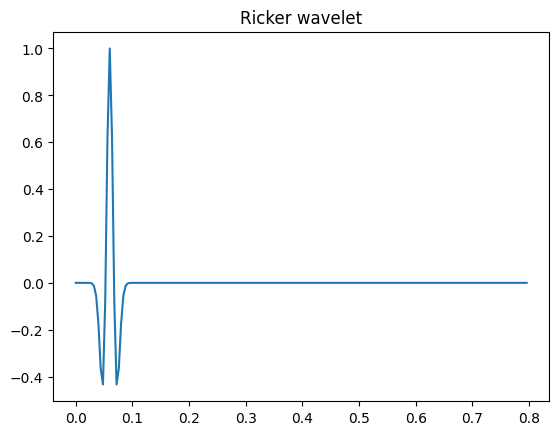

In [6]:

# define the actual modeling parameters

ntmod=1024
nxmod=1024
dt=0.004
dx=10.0
alpha=-1
ntrot=15
t0=ntrot*dt
fp=30
wav=seistools.gen_ricker(ntmod,dt,fp,t0)

tax=dt*np.arange(ntmod)
xax=dx*np.arange(nxmod)-(dx*(nxmod//2))

plt.figure()
plt.plot(tax[0:min(200,ntmod)],wav[0:min(200,ntmod)])
plt.title('Ricker wavelet')
plt.show()


Set up the Kennett's reflecitivty modeling and carry out the modeling

In [7]:
# start the KennettSolver class

model=Kennett.KennettSolver(vplog,vslog,rholog,dz)

# the modeling gives 4 datasets, we will use only PP, k=0

type=['PP','PS','SP','SS']

tmp=model.solve(nt=ntmod,nx=nxmod,dt=dt,dx=dx,surfmul=0,intmul=0,alpha=alpha,wavelet=wav,ntrot=-ntrot)


Start Kennett modeling
tkxax=0.950946 toper=5.35894 tcalc=2.53343 tend=0.280512


The method generates four responses PP, PS, SP and SS; we will only use PP

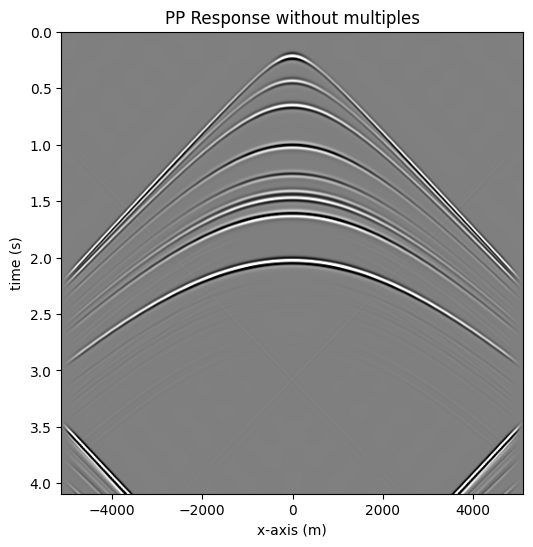

In [8]:
# select the PP component: k=0
k=0

# also select smaller x-t window for further processing
nt=512
nx=800

# inverse FFT to get the data in x-t domain
# note that the x-t data has shape [nt,nx]
tmp_PP=np.fft.fftshift(tmp[k],axes=1)
nxbuf=(nxmod-nx)//2
data_PP=tmp_PP[0:nt,nxbuf:nxbuf+nx]

# apply lateral taper to the data to reduce edge effects
nxtap=40
for ix in range(nxtap):
    tap=np.sin(ix*np.pi*0.5/nxtap)**2
    data_PP[:,ix]=tap*data_PP[:,ix]
    if ix > 0:
        data_PP[:,nx-ix]=tap*data_PP[:,nx-ix]

# make a display of the PP shot record/CMP gather
vmax=np.max(np.abs(data_PP))/5.0
vmin=-vmax
plt.figure(figsize=(8,6))
plt.imshow(data_PP,extent=[xax[0],xax[-1],tax[-1],tax[0]],vmin=vmin,vmax=vmax,cmap='gray',aspect=dx/dt)
plt.xlabel('x-axis (m)')
plt.ylabel('time (s)')
plt.title(type[k]+' Response without multiples')
plt.show()


### Step 3: Angle-dependent imaging via linear Radon domain

Apply linear Radon/Tau-P transform of the data, to decompose in plane wave responses

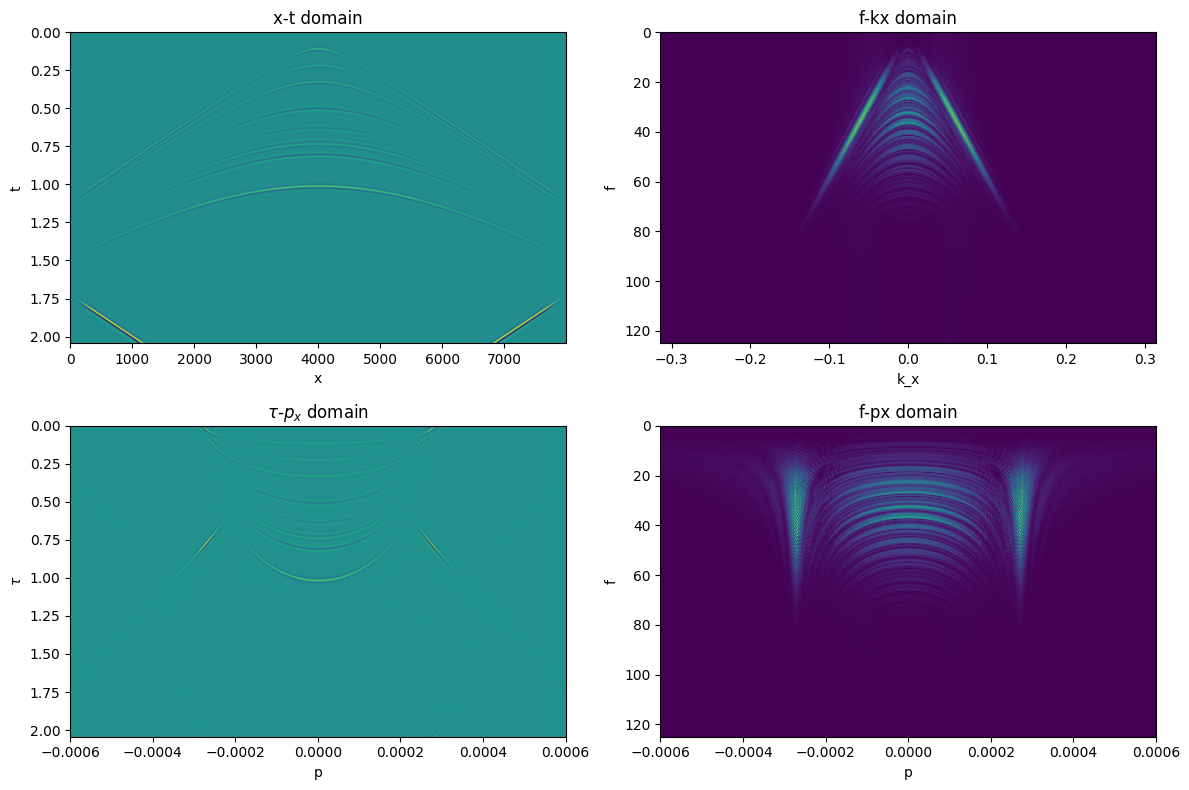

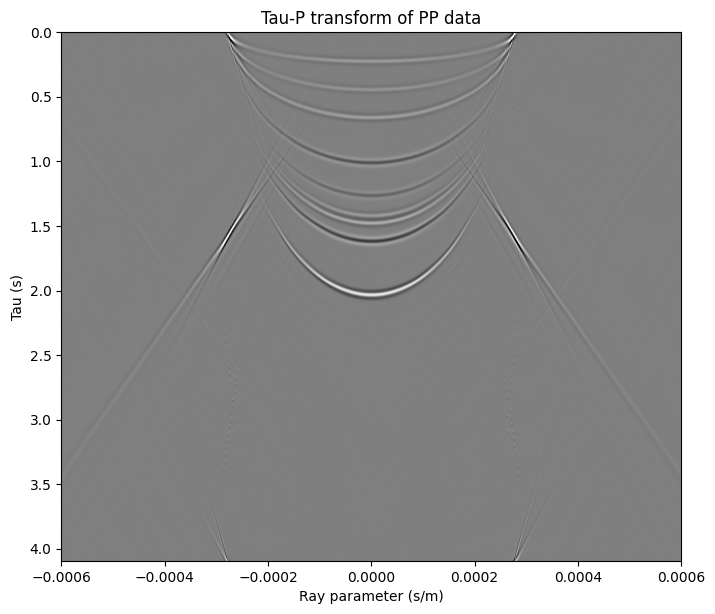

In [9]:
pmin=-0.6e-3
pmax=0.6e-3
dp=2e-6
paxis=np.arange(pmin,pmax+0.1*dp,dp)
ntr=len(paxis) # do not use "np" as this is already numpy

# apply forward Tau-P transform

data_tp=seistools.taup(data_PP,(nx/2)*dx, dt, dx, pmin, pmax, ntr, plot=True)

# plot the Tau-P data

maxtp=np.max(np.abs(data_tp))/2
plt.figure(figsize=(8,10))
plt.imshow(data_tp,extent=[paxis[0],paxis[-1],tax[-1],tax[0]],vmin=-maxtp,vmax=maxtp,cmap='gray',aspect=0.5*dp/dt)
plt.xlabel('Ray parameter (s/m)')
plt.ylabel('Tau (s)')
plt.title("Tau-P transform of PP data")
plt.show()




For the imaging we need a smooth background velocity model

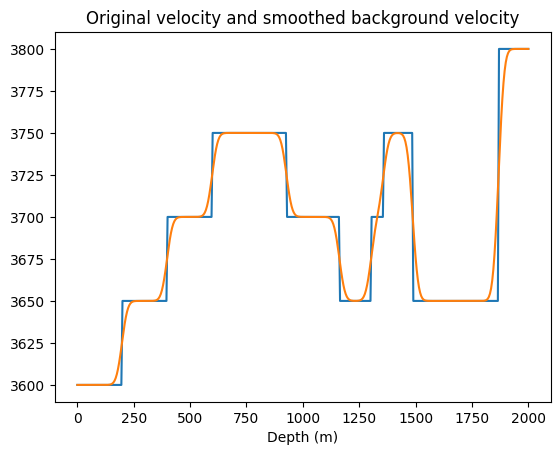

In [10]:
# create smooth background velocity

vpback = 1/gaussian_filter1d(1/vplog, 4)
plt.figure()
plt.plot(zlog,vplog)
plt.plot(zlog,vpback)
plt.xlabel('Depth (m)')
plt.title("Original velocity and smoothed background velocity")
plt.show()


#### Do the actual migration via phase shifts in Tau-P domain

/tmp/ipykernel_1480896/2813152862.py:16: RuntimeWarning: invalid value encountered in sqrt
  pz=np.sqrt(p0**2-paxis**2)


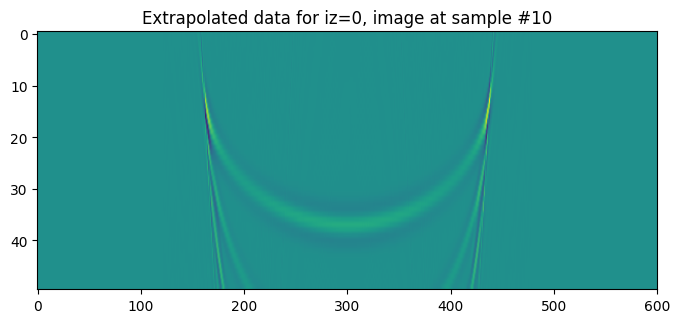

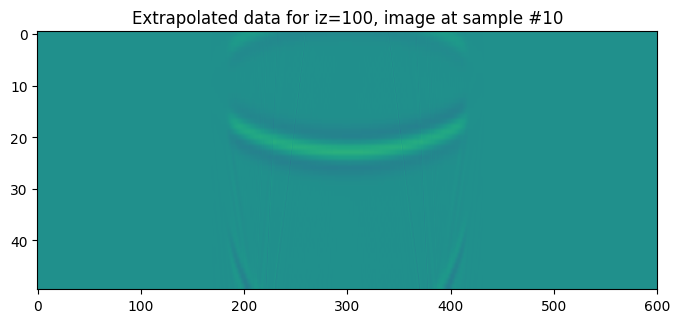

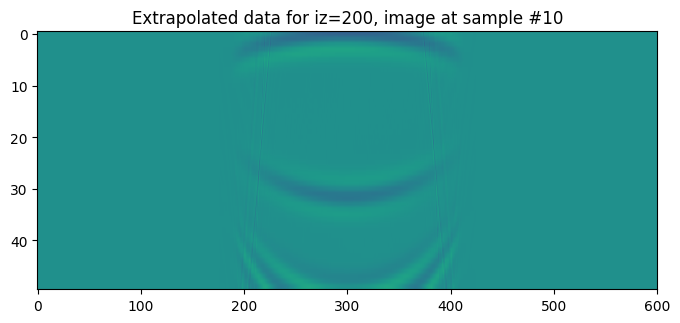

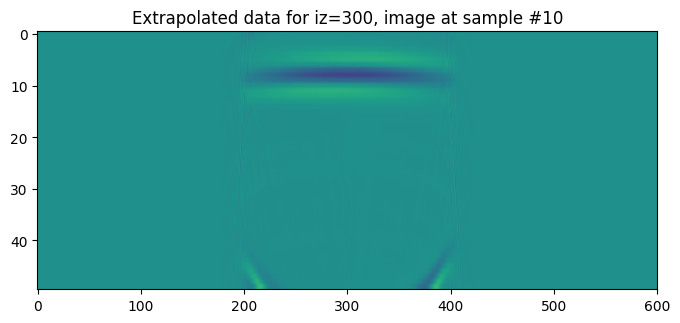

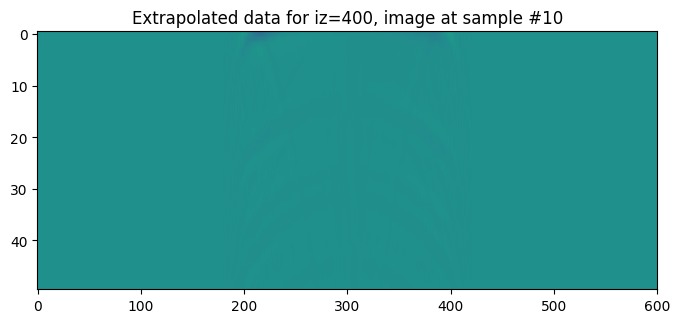

In [11]:
# apply inverse extrapolation towards each layer

data_extrap=np.copy(data_tp)
angle_image=np.zeros((nz,ntr))
# for unknown reasons we need to subtract 0.5dp from the axis to make flat images
#paxis=paxis-dp
paxis=paxis-0.5*dp
for iz in range(nz):
    data_om = np.fft.rfft(data_extrap,axis=0)
    nom=data_om.shape[0]
    fmax=1/(2.0*dt)
    dom=2*np.pi*fmax/(nom-1)
    data_om_extrap=0.0*data_om
    vp=vpback[iz]
    p0=1/vp
    pz=np.sqrt(p0**2-paxis**2)
    pz[np.isnan(pz)] = 0
    # make a mask=0 where pz=0, use smooth edges via Gaussian
    mask=np.abs(pz)/(np.abs(pz)+1e-20)
    mask=gaussian_filter1d(mask,10)
    # apply extrapolation for all frequencies
    for iom in range(nom):
        om=iom*dom
        # remove NaNs in the calculation, make them zero
        shift=np.exp(1j*2*om*pz*dz)
        data_om_extrap[iom,:]=mask*shift*data_om[iom,:]
    
    data_extrap = np.fft.irfft(data_om_extrap,axis=0)
    angle_image[iz,:]=data_extrap[0,:]
    # for QC display back-propagated wavefield for few depth levels
    if iz%100==0:
        data_roll = np.roll(data_extrap,10,axis=0)
        plt.figure(figsize=(8,10))
        plt.imshow(data_roll[0:50,:],vmin=-maxtp,vmax=maxtp,aspect=5)
        plt.title("Extrapolated data for iz=%d, image at sample #10" %(iz))
        plt.show()


Display the angle-dependent imaging in Ray-parameter-Depth domain

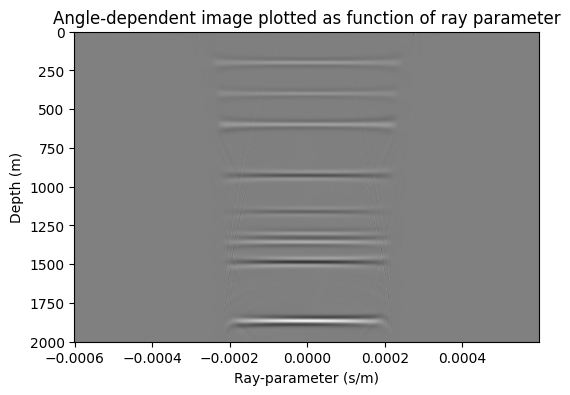

In [12]:
# display final image as function of ray-parameter

plt.figure(figsize=(6,6))
plt.imshow(angle_image,extent=[paxis[0],paxis[-1],zlog[-1],zlog[0]], \
           vmin=-maxtp,vmax=maxtp,cmap='gray',aspect=1.0*dp/dz)
plt.xlabel('Ray-parameter (s/m)')
plt.ylabel('Depth (m)')
plt.title('Angle-dependent image plotted as function of ray parameter')
plt.show()


### Step 4: Reformat the image domain to sin(angle) and sin^2(angle)

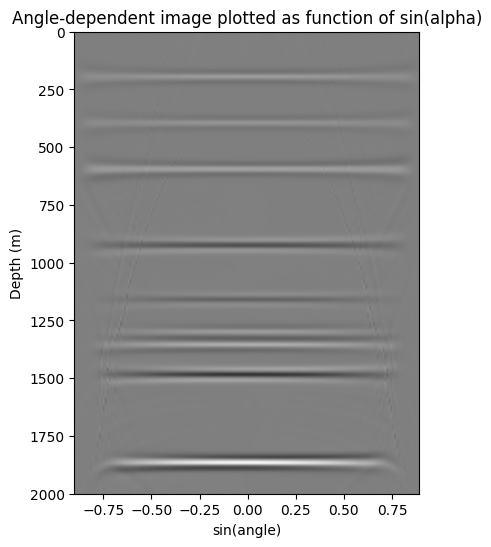

In [13]:
# re-interpolate the image from sin(alpha)/c to sin(alpha)

dsin=0.01
sinaxis=np.arange(-0.9,0.9,dsin)
nsin=len(sinaxis)
sin_image=np.zeros((nz,nsin))
for iz in range(nz):
    vp=vpback[iz]
    p0=1/vp
    sinaxis_in=vp*paxis
    datin=angle_image[iz,:]
    datout=np.interp(sinaxis,sinaxis_in,datin)
    sin_image[iz,:]=datout

# display final image as function of sin(alpha)

plt.figure(figsize=(6,6))
plt.imshow(sin_image,extent=[sinaxis[0],sinaxis[-1],zlog[-1],zlog[0]], \
           vmin=-maxtp,vmax=maxtp,cmap='gray',aspect=0.6*dsin/dz)
plt.xlabel('sin(angle)')
plt.ylabel('Depth (m)')
plt.title('Angle-dependent image plotted as function of sin(alpha)')
plt.show()

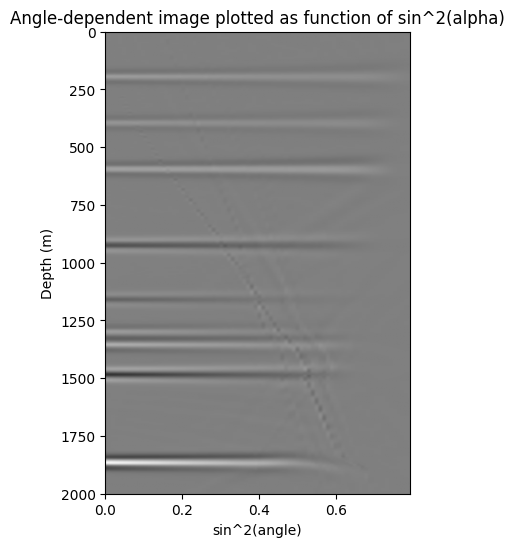

Note that sin(30)=0.5, so sin^2(30)=0.25, which is the usual range for AVO analysis


In [14]:
# Re-interpolate the image as function of sin^(alpha) for positive alphas

dsin2=0.01
sin2axis=np.arange(0.0,0.8,dsin2)
nsin2=len(sin2axis)
sin2_image=np.zeros((nz,nsin2))
for iz in range(nz):
    vp=vpback[iz]
    p0=1/vp
    sin2axis_in=np.sign(paxis)*(vp*paxis)**2
    datin=angle_image[iz,:]
    datout=np.interp(sin2axis,sin2axis_in,datin)
    sin2_image[iz,:]=datout

# display final image as function of sin^2(alpha)

plt.figure(figsize=(6,6))
plt.imshow(sin2_image,extent=[sin2axis[0],sin2axis[-1],zlog[-1],zlog[0]], \
           vmin=-maxtp,vmax=maxtp,cmap='gray',aspect=0.30*dsin2/dz)
plt.xlabel('sin^2(angle)')
plt.ylabel('Depth (m)')
plt.title('Angle-dependent image plotted as function of sin^2(alpha)')
plt.show()

print('Note that sin(30)=0.5, so sin^2(30)=0.25, which is the usual range for AVO analysis')

### Step 5: Analyze the reflection curves via Shuey's approximation

#### Define a function that calculate intercept R0 and Gradient G from elastic parameters

See this link for Shuey's equation: <https://en.wikipedia.org/wiki/Zoeppritz_equations>

In [16]:
# define the intercept and gradient from Shuey's equation

def shuey_2term_forward(rho1,rho2,vp1,vp2,vs1,vs2):
    # define background values
    vp=(vp1+vp2)/2.0
    vs=(vs1+vs2)/2.0
    rho=(rho1+rho2)/2.0
    # define contrasts
    drho=(rho2-rho1)/rho
    dvp=(vp2-vp1)/vp
    dvs=(vs2-vs1)/vs
    # define square of vp and vs
    vp2=vp*vp
    vs2=vs*vs
    # calculate the interrcept and gradient
    R0=0.5*(drho+dvp)
    G=0.5*dvp-2.0*(vs2/vp2)*(drho+2.0*dvs)
    # return the intercept and gradient
    return R0,G

#### Now plot the found angle-dependent reflection curve at each interface and compare to Shuey

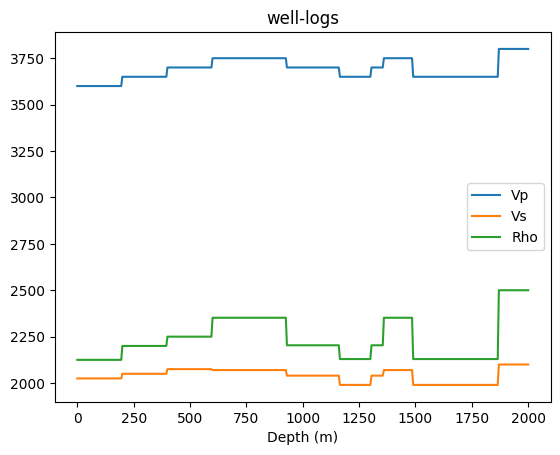

In [17]:
# Re-plot the original logs for reference

plt.figure()
plt.plot(zlog,vplog,label='Vp')
plt.plot(zlog,vslog,label='Vs')
plt.plot(zlog,rholog,label='Rho')
plt.xlabel('Depth (m)')
plt.title('well-logs')
plt.legend()
plt.show()

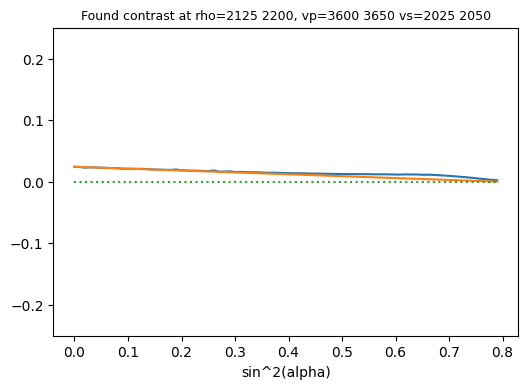

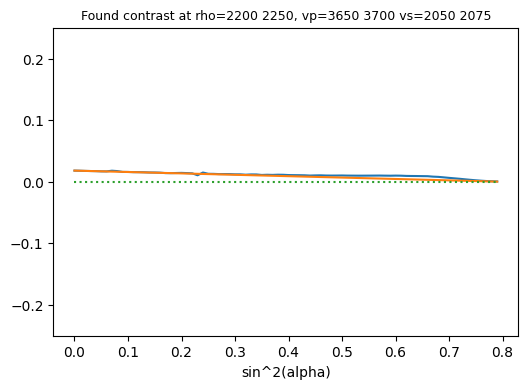

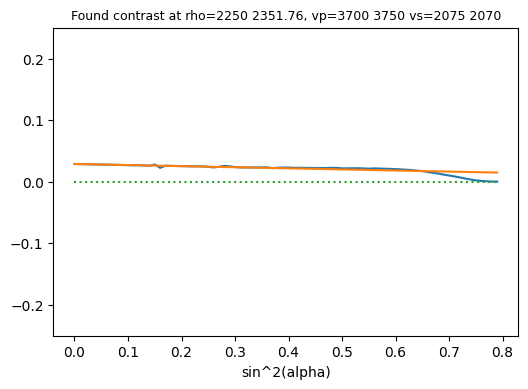

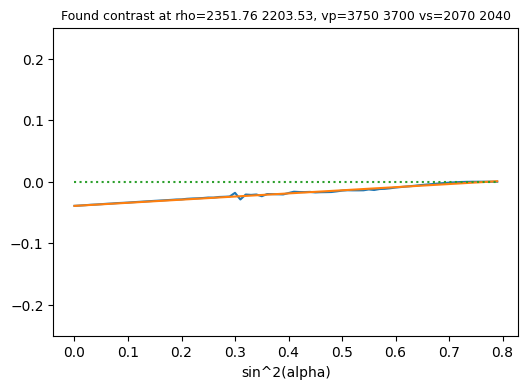

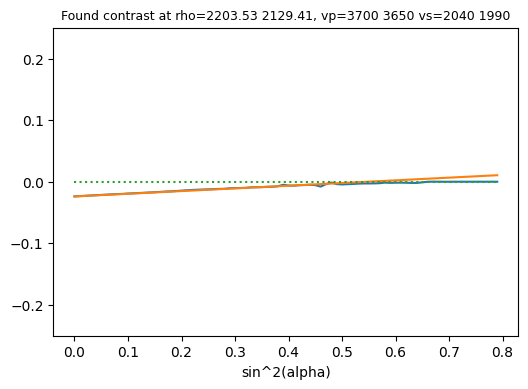

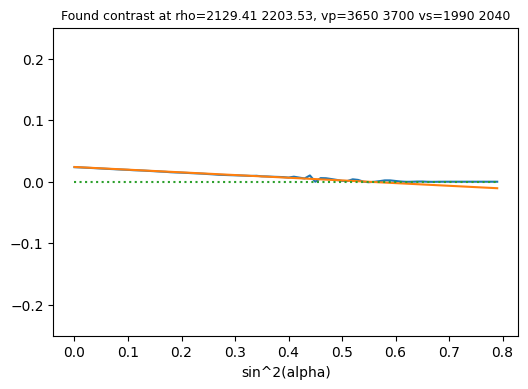

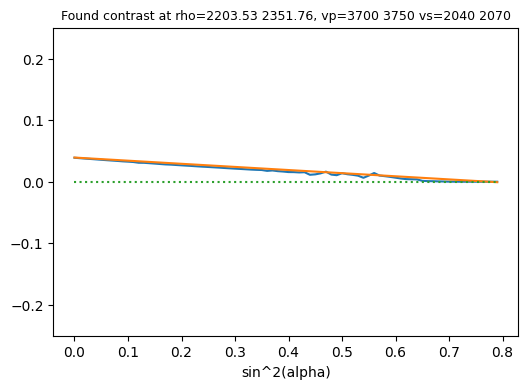

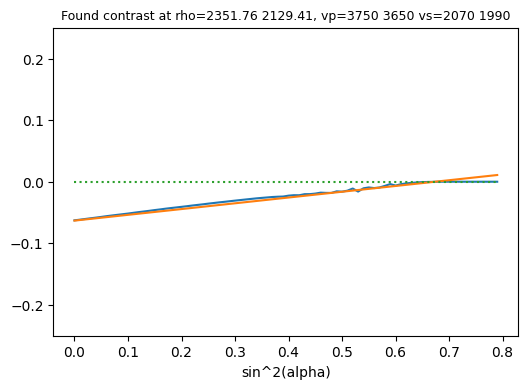

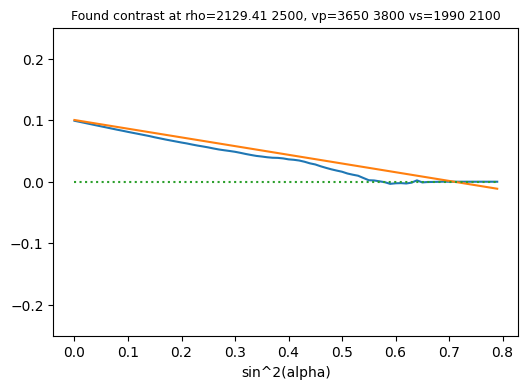

In [21]:
# scan the true model for contrasts and then 
# compare the intercept and gradient with the imaged data
# Also, create an ideal angle gather by imposing a spike
# wavelet on an empty gather

sin2_image_ideal = 0.0*sin2_image


ymin=-0.25
ymax=0.25
for iz in range(nz-1):
    if np.abs(vplog[iz+1]-vplog[iz]) > 1.0:
        # found contrast, calculate the true intercept/gradient
        rho1=rholog[iz]
        rho2=rholog[iz+1]
        vp1=vplog[iz]
        vp2=vplog[iz+1]
        vs1=vslog[iz]
        vs2=vslog[iz+1]
        R0,G=shuey_2term_forward(rho1,rho2,vp1,vp2,vs1,vs2)
        # store the ideal angle gather
        sin2_image_ideal[iz,:]=R0+G*sin2axis
        # make plot of the imaged data and plot true trend on top
        plt.figure(figsize=(6,4))
        plt.plot(sin2axis,sin2_image[iz,:])
        plt.plot(sin2axis,R0+G*sin2axis)
        plt.plot(sin2axis,0.0*sin2axis,':')
        plt.xlabel('sin^2(alpha)')
        ax = plt.gca()
        ax.set_ylim([ymin, ymax])
        plt.title('Found contrast at rho=%g %g, vp=%g %g vs=%g %g' \
            %(rho1,rho2,vp1,vp2,vs1,vs2),fontsize=9)
        plt.show()


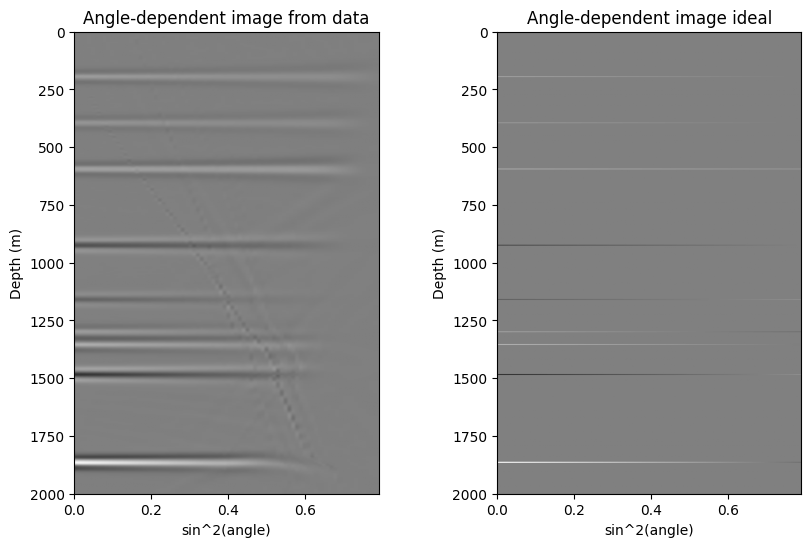

In [22]:
# display final image as function of sin^2(alpha)

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(sin2_image,extent=[sin2axis[0],sin2axis[-1],zlog[-1],zlog[0]], \
           vmin=-maxtp,vmax=maxtp,cmap='gray',aspect=0.30*dsin2/dz)
plt.xlabel('sin^2(angle)')
plt.ylabel('Depth (m)')
plt.title('Angle-dependent image from data')
plt.subplot(1,2,2)
plt.imshow(sin2_image_ideal,extent=[sin2axis[0],sin2axis[-1],zlog[-1],zlog[0]], \
           vmin=-maxtp,vmax=maxtp,cmap='gray',aspect=0.30*dsin2/dz)
plt.xlabel('sin^2(angle)')
plt.ylabel('Depth (m)')
plt.title('Angle-dependent image ideal')
plt.show()


### Apply LS fitting of the ideal angle gather to the data gather

- We can define per angle a filter to fit the ideal angle gather to the data
- We exclude the overburden for the fitting (not fullfilling Shuey's apprximation)
- These filters can be used later on to transform ideal angle gathers to data gathers


found sin2max=0.413176 at k=42
found 160 z-levels in overburden


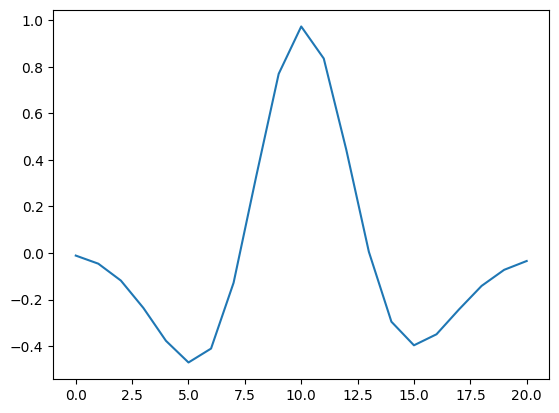

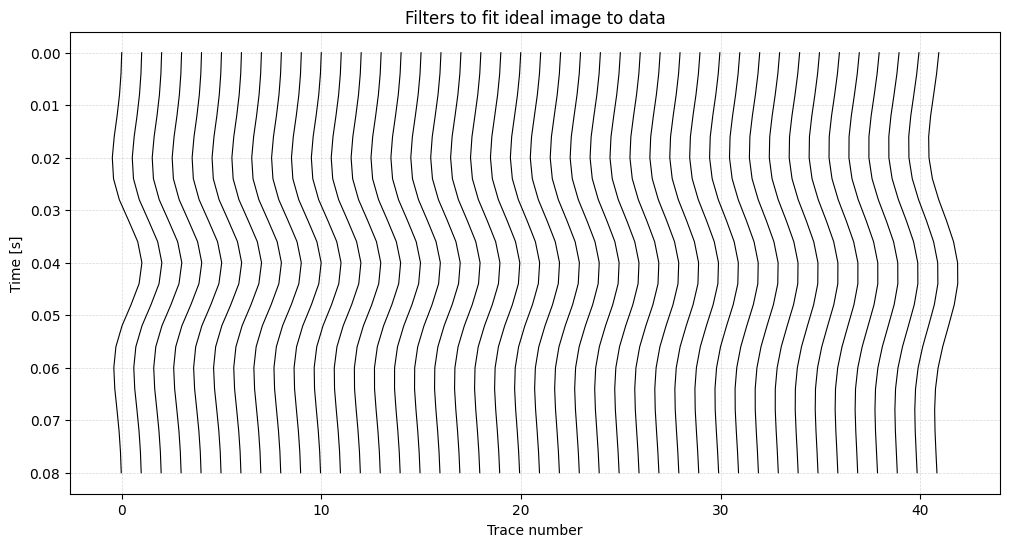

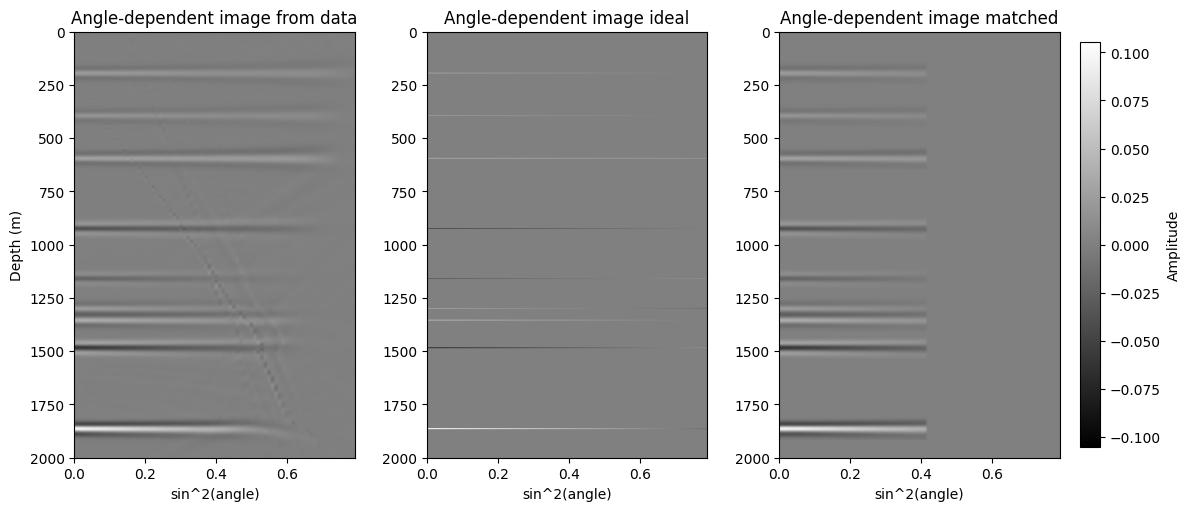

In [24]:
# define maximum angle to fit

alpha_max=40

# find the index in the sin^2 axis

sin2max=np.sin(alpha_max*np.pi/180.)**2
for k,sin2 in enumerate(sin2axis):
    if sin2 > sin2max:
        kmax=k
        break

print('found sin2max=%f at k=%d' %(sin2max,kmax))

# find number of z-layers of overburden, we want to exclude them in the fitting

zrange_over=np.sum(zlayer_over)
nz_over=int(zrange_over/dz)

print('found %d z-levels in overburden' %nz_over)

# define output for fitting of ideal image

sin2_image_fit = 0.0*sin2_image

# find the kmax filters in groups of nkfilt
nkfilt=10
lfilt=21
eps=0.001
filt_fit=np.zeros((kmax,lfilt))
for k in range(kmax):
    k0=max(0,k-nkfilt//2)
    dat=sin2_image[nz_over:,k0:k0+nkfilt]
    mod=sin2_image_ideal[nz_over:,k0:k0+nkfilt]
    dat_sub,filt_fit[k,:]=seistools.LSsub(dat.T,mod.T,lfilt,eps)

# apply the convolution filters to the ideal image data

lfilth=lfilt//2
for k in range(kmax):
    tmp=np.convolve(sin2_image_ideal[:,k],filt_fit[k,:],mode='full')
    sin2_image_fit[:,k]=tmp[lfilth:nz+lfilth]

# dispay the filters as a wiggle plot

plt.figure()
plt.plot(filt_fit[0,:])
plt.show()
seistools.wiggle_plot(filt_fit.T,title='Filters to fit ideal image to data')

# display final images as function of sin^2(alpha)

# display final images as function of sin^2(alpha)

fig, axes = plt.subplots(1, 3, figsize=(12, 5), constrained_layout=True)

im0 = axes[0].imshow(
    sin2_image,
    extent=[sin2axis[0], sin2axis[-1], zlog[-1], zlog[0]],
    vmin=-maxtp, vmax=maxtp, cmap="gray",
    aspect=0.30 * dsin2 / dz
)
axes[0].set_xlabel("sin^2(angle)")
axes[0].set_ylabel("Depth (m)")
axes[0].set_title("Angle-dependent image from data")

im1 = axes[1].imshow(
    sin2_image_ideal,
    extent=[sin2axis[0], sin2axis[-1], zlog[-1], zlog[0]],
    vmin=-maxtp, vmax=maxtp, cmap="gray",
    aspect=0.30 * dsin2 / dz
)
axes[1].set_xlabel("sin^2(angle)")
axes[1].set_title("Angle-dependent image ideal")

im2 = axes[2].imshow(
    sin2_image_fit,
    extent=[sin2axis[0], sin2axis[-1], zlog[-1], zlog[0]],
    vmin=-maxtp, vmax=maxtp, cmap="gray",
    aspect=0.30 * dsin2 / dz
)
axes[2].set_xlabel("sin^2(angle)")
axes[2].set_title("Angle-dependent image matched")

# one shared colorbar on the right
cbar = fig.colorbar(im2, ax=axes, location="right", shrink=0.95, pad=0.02)
cbar.set_label("Amplitude")

plt.show()



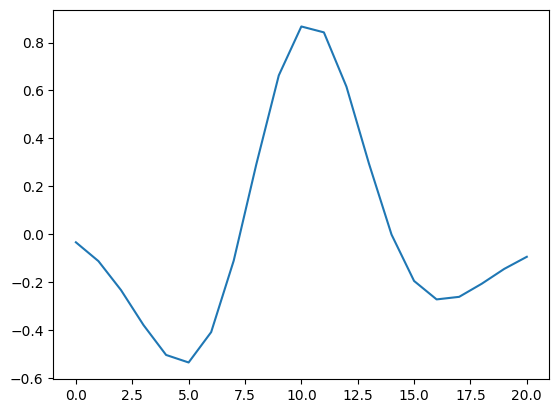

In [32]:
plt.figure()
plt.plot(filt_fit[30,:])

In [40]:
print(sin2_image_ideal.shape)

(401, 80)


In [41]:
wav_array_0 = np.array(filt_fit[0,:])         
np.save('wavelet_0.npy', wav_array_0)  
wav_array_1 = np.array(filt_fit[10,:])         
np.save('wavelet_1.npy', wav_array_1)  
wav_array_2 = np.array(filt_fit[20,:])         
np.save('wavelet_2.npy', wav_array_2) 
wav_array_3 = np.array(filt_fit[30,:])         
np.save('wavelet_3.npy', wav_array_3)  